In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
GMM Full Pipeline v2: Merges new ingredient data with price, performs feature
engineering with only PRICE_PER_100G, conducts K-sweep (Elbow Curve),
automatically selects optimal K, builds the k-partite graph, and plots a NetworkX visualization.
"""

# -----------------------------
# Standard library imports
# -----------------------------
import json
import argparse
import math
import logging
from pathlib import Path
from collections import defaultdict

# -----------------------------
# Third-party imports
# -----------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm
from rapidfuzz.fuzz import token_sort_ratio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import sparse
from scipy.stats import zscore
import networkx as nx
import joblib
import matplotlib.pyplot as plt

# -----------------------------
# Configuration (tweak as needed)
# -----------------------------
RANDOM_SEED = 42
data_dir = "../data"
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Feature config
TFIDF_NGRAM_RANGE = (1, 2)
TFIDF_MAX_FEATURES = 50000
PCA_COMPONENTS = 96
TOP_N_AISLES = 200
TEXT_SVD_COMPONENTS = 50 # SVD dimensions for text features

# Bucketing (P1) config
BUCKET_NAME_SIM_THRESHOLD = 0.92
BUCKET_PRICE_TOL_PCT = 0.10

# GMM sweep and final config
K_GRID = list(range(16, 129, 16)) # [16, 32, 48, 64, 80, 96, 112, 128]
COV_TYPES = ["full"] # Use full covariance for final model
GMM_N_INIT = 3
GMM_MAX_ITER = 300
TINY_COMPONENT_WEIGHT = 0.001

# Graph config
P3_LEVEL = "aisle_id"
P2P_SIM_PRUNE = 0.20
P2P_MAX_EDGES_PER_NODE = 15
P2P_FALLBACK_WEIGHT = 0.20

# -----------------------------
# Logging setup
# -----------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# -----------------------------
# Utility functions
# -----------------------------
def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)

def cos_sim(a, b):
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(a @ b / denom) if denom > 0 else 0.0

# -----------------------------
# Data Loading and Merging
# -----------------------------
def load_tables(data_dir: Path):
    """Load and selectively merge ONLY PRICE data onto the primary map file."""

    # NOTE: Assumes folder structure data_dir/raw and data_dir/processed
    primary_source_path = data_dir / "processed" / "product_data_with_ingredient_mapped.csv"
    price_source_path = data_dir / "raw" / "products_with_prices_ingredients_nutrition.csv"

    # --- Load Primary/Map Data ---
    if not primary_source_path.exists():
        raise FileNotFoundError(f"Primary map file not found: {primary_source_path}")

    products_map = pd.read_csv(primary_source_path)
    products_map.columns = [c.lower().replace(" ", "_").replace(",", "") for c in products_map.columns]

    if 'product_id' not in products_map.columns:
        products_map = products_map.rename(columns={products_map.columns[0]: 'product_id'})
    products_map['product_id'] = pd.to_numeric(products_map['product_id'], errors='coerce').astype('Int64')
    products_map = products_map.dropna(subset=['product_id'])

    # --- Load Price Data ---
    if not price_source_path.exists():
        raise FileNotFoundError(f"Price source file not found: {price_source_path}")

    products_price = pd.read_csv(price_source_path)
    products_price.columns = [c.lower().replace(" (usd)", "_usd").replace(" (g)", "_g").replace(" ", "_") for c in products_price.columns]

    # Identify ONLY price column to keep (price_usd)
    PRICE_COLS = ['product_id', 'price_usd']
    products_price_subset = products_price[PRICE_COLS]

    # --- Perform Selective Merge ---
    products = products_map.merge(products_price_subset, on='product_id', how='left')

    # Load lookup tables (assuming they are in the data_dir/raw)
    aisles = pd.read_csv(data_dir / "raw" / "aisles.csv")
    departments = pd.read_csv(data_dir / "raw" / "departments.csv")

    logging.info("Data loaded and selectively merged (Price only).")

    return {"products": products, "aisles": aisles, "departments": departments}

# -----------------------------
# Data Preprocessing and Feature Engineering
# -----------------------------
def normalize_products(df: pd.DataFrame) -> pd.DataFrame:
    """Derives price_per_100g, imputes, and cleans column names."""
    df = df.copy()

    expected_cols = {"product_id","product_name_x","aisle_id","department_id","price_usd","ingredients_text"}
    if not expected_cols.issubset(set(df.columns)):
         raise ValueError("Missing required columns after merge. Check product_data_with_ingredient_mapped.csv structure.")

    # --- Derive price_per_100g ---
    size_vals = []
    for name in df["product_name_x"].fillna(""):
        tokens = [t for t in name.replace("oz"," ").replace("ml"," ").replace("g"," ").split() if t.replace(".","",1).isdigit()]
        size_val = float(tokens[-1]) if tokens else np.nan
        size_vals.append(size_val)
    df["size_value_guess"] = size_vals

    df["price_per_100g"] = np.where(
        df["size_value_guess"].notna() & (df["size_value_guess"] > 0),
        df["price_usd"] / df["size_value_guess"] * 100.0,
        np.nan
    )

    # --- Clipping & Imputation (PRICE ONLY) ---
    PER_100G_COLS = ["price_per_100g"]
    df["price_per_100g"] = df["price_per_100g"].clip(lower=0.01, upper=100.0)

    for col in PER_100G_COLS:
        df[col] = df.groupby("aisle_id")[col].transform(lambda s: s.fillna(s.median()))
        df[col] = df[col].fillna(df[col].median())

    df = df.rename(columns={'product_name_x': 'product_name', 'ingredients_text': 'ingredients'})
    return df

def build_product_features(products: pd.DataFrame, aisles: pd.DataFrame):
    """Creates reduced feature matrix (Text SVD + Scaled Price + OHE Aisle)."""
    df = products.copy()
    PER_100G_COLS = ["price_per_100g"]

    # Meta columns for record keeping
    meta_cols = ["product_id", "product_name", "aisle_id", "department_id", "price_usd", "price_per_100g", "ingredients"]
    meta = df[meta_cols].copy()

    # 1. Text Features (TF-IDF + Truncated SVD)
    text_series = (df["product_name"].fillna("") + " " + df["ingredients"].fillna("")).astype(str)
    tfidf = TfidfVectorizer(ngram_range=TFIDF_NGRAM_RANGE, max_features=TFIDF_MAX_FEATURES, stop_words="english", sublinear_tf=True)
    X_text_sparse = tfidf.fit_transform(text_series)

    svd_text = TruncatedSVD(n_components=TEXT_SVD_COMPONENTS, random_state=RANDOM_SEED)
    X_text_reduced = svd_text.fit_transform(X_text_sparse)

    # 2. Numeric Block (PRICE ONLY, Robust Scaled)
    numeric = df[PER_100G_COLS].astype(float)
    scaler = RobustScaler()
    X_num = scaler.fit_transform(numeric)

    # 3. One-hot top aisles
    top_aisle_ids = df["aisle_id"].value_counts().nlargest(TOP_N_AISLES).index.tolist()
    aisle_mapped = df["aisle_id"].where(df["aisle_id"].isin(top_aisle_ids), other=-1)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    X_aisle = ohe.fit_transform(aisle_mapped.values.reshape(-1,1))

    # 4. Concatenate and reduce dimensionality again (combining text, price, aisle)
    X_num_sparse = sparse.csr_matrix(X_num)
    X_combined_sparse = sparse.hstack([sparse.csr_matrix(X_text_reduced), X_num_sparse, X_aisle], format="csr")

    # Final SVD reduction to PCA_COMPONENTS (96)
    svd_final = TruncatedSVD(n_components=PCA_COMPONENTS, random_state=RANDOM_SEED)
    X_product_pca = svd_final.fit_transform(X_combined_sparse)

    # Persist transformers for reproducibility
    feat_dir = ARTIFACTS_DIR / "features"; ensure_dir(feat_dir)
    joblib.dump(svd_final, feat_dir / "svd_final.joblib")
    meta.to_parquet(feat_dir / "meta_product.parquet", index=False, engine="fastparquet")
    np.save(feat_dir / "X_product_pca.npy", X_product_pca)

    return X_product_pca, meta

# -----------------------------
# Bucketing and Aggregation (Standard V1 Logic)
# -----------------------------
def make_buckets(meta: pd.DataFrame) -> pd.DataFrame:
    """Cluster near-duplicates into BucketID."""
    def parse_brand(name: str) -> str:
        toks = name.split()
        return toks[0].lower() if toks else ""
    def parse_type(name: str) -> str:
        toks = name.split()
        return " ".join(t.lower() for t in toks[1:3]) if len(toks) > 1 else ""

    meta = meta.copy()
    meta["brand"] = meta["product_name"].fillna("").map(parse_brand)
    meta["type"] = meta["product_name"].fillna("").map(parse_type)

    bucket_ids = {}; next_bucket = 1

    for (_, _, aisle_id), block in tqdm(meta.groupby(["brand","type","aisle_id"], dropna=False), desc="Bucketing blocks"):
        idxs = list(block.index)
        parent = {i: i for i in idxs}

        def find(i):
            while parent[i] != i: parent[i] = parent[parent[i]]; i = parent[i]
            return i

        def union(i, j):
            ri, rj = find(i), find(j)
            if ri != rj: parent[rj] = ri

        for a in range(len(idxs)):
            for b in range(a+1, len(idxs)):
                i, j = idxs[a], idxs[b]
                name_i = block.loc[i, "product_name"] or ""; name_j = block.loc[j, "product_name"] or ""
                sim = token_sort_ratio(name_i, name_j) / 100.0

                pi = block.loc[i, "price_per_100g"]; pj = block.loc[j, "price_per_100g"]
                if pd.isna(pi) or pd.isna(pj) or max(pi, pj, 1e-6) == 0: price_ok = False
                else: price_ok = (abs(pi - pj) / max(pi, pj, 1e-6)) <= BUCKET_PRICE_TOL_PCT

                if sim >= BUCKET_NAME_SIM_THRESHOLD and price_ok: union(i, j)

        root_to_bucket = {}
        for i in idxs:
            r = find(i)
            if r not in root_to_bucket:
                root_to_bucket[r] = next_bucket
                next_bucket += 1
            bucket_ids[block.loc[i, "product_id"]] = root_to_bucket[r]

    bmap = pd.DataFrame({"product_id": list(bucket_ids.keys()), "bucket_id": list(bucket_ids.values())})
    bdir = ARTIFACTS_DIR / "buckets"; ensure_dir(bdir)
    bmap.to_parquet(bdir / "product_to_bucket.parquet", index=False, engine="fastparquet")

    stats = meta.merge(bmap, on="product_id", how="left") \
                .groupby("bucket_id").agg(size=("product_id","count"), mean_price_per_100g=("price_per_100g","mean")).reset_index()
    stats.to_parquet(bdir / "bucket_stats.parquet", index=False, engine="fastparquet")
    return bmap

def average_by_bucket(X_prod_pca: np.ndarray, meta: pd.DataFrame, bmap: pd.DataFrame):
    """Average reduced product features within each bucket → bucket vectors."""
    meta_b = meta.merge(bmap, on="product_id", how="left")
    buckets = meta_b["bucket_id"].values
    uniq_buckets, inv = np.unique(buckets, return_inverse=True)
    sums = np.zeros((len(uniq_buckets), X_prod_pca.shape[1]), dtype=np.float32)
    counts = np.zeros(len(uniq_buckets), dtype=np.int64)

    for i, bi in enumerate(inv):
        sums[bi] += X_prod_pca[i]
        counts[bi] += 1

    X_bucket = (sums.T / np.clip(counts, 1, None)).T
    bucket_index = pd.DataFrame({"bucket_id": uniq_buckets})

    fdir = ARTIFACTS_DIR / "features"; ensure_dir(fdir)
    np.save(fdir / "X_bucket_pca.npy", X_bucket)
    bucket_index.to_parquet(fdir / "bucket_index.parquet", index=False, engine="fastparquet")

    return X_bucket, bucket_index

# -----------------------------
# GMM Sweep and Selection (MODIFIED for evaluation)
# -----------------------------
def sweep_gmm_metrics(X_bucket: np.ndarray):
    """Fits GMM for all K in the grid and collects BIC/AIC/Silhouette metrics."""
    all_results = []
    logging.info(f"Starting K-sweep for K in {K_GRID} with {COV_TYPES[0]} covariance.")

    for k in K_GRID:
        # Initialize metric variables to prevent KeyError if calculation fails
        sil, db, ch, gmm = np.nan, np.nan, np.nan, None

        try:
            gmm = GaussianMixture(
                n_components=k, covariance_type=COV_TYPES[0], n_init=GMM_N_INIT,
                max_iter=GMM_MAX_ITER, random_state=RANDOM_SEED
            ).fit(X_bucket)

            bic = gmm.bic(X_bucket)
            aic = gmm.aic(X_bucket)
            tiny_frac = (gmm.weights_ < TINY_COMPONENT_WEIGHT).mean()
            labels = gmm.predict(X_bucket)

            # Compute external metrics only if the fit is stable (k>1 and tiny_frac is low)
            if k > 1 and tiny_frac <= 0.20:
                sil = silhouette_score(X_bucket, labels)
                db  = davies_bouldin_score(X_bucket, labels)
                ch  = calinski_harabasz_score(X_bucket, labels)

            logging.info(f"GMM sweep k={k} BIC={bic:.1f} tinyFrac={tiny_frac:.3f} sil={sil:.3f}")

            # --- Append result to list ---
            all_results.append({
                "k": k, "bic": bic, "aic": aic, "silhouette": sil,
                "davies_bouldin": db, # Safely defined
                "calinski_harabasz": ch, "tiny_frac": tiny_frac, "model": gmm
            })

        except Exception as e:
            # If GMM fitting or prediction fails, log the error and skip
            logging.error(f"Failed to fit GMM for k={k}: {e}")
            # Append a partial result so the subsequent DataFrame is not broken
            all_results.append({
                "k": k, "bic": np.nan, "aic": np.nan, "silhouette": np.nan,
                "davies_bouldin": np.nan, "calinski_harabasz": np.nan,
                "tiny_frac": np.nan, "model": None
            })
            continue

    return pd.DataFrame(all_results)

def suggest_optimal_k(results_df: pd.DataFrame):
    """Calculates a meta-score to suggest the optimal K."""
    df_f = results_df[results_df["model"].notna()].copy()

    # Ensure stable fit before suggesting
    df_f = df_f[df_f["tiny_frac"] <= 0.10].reset_index(drop=True)
    if df_f.empty:
         raise RuntimeError("No models passed the tiny component sanity check. Cannot suggest optimal K.")

    # Fill NaNs with median for stable z-scoring
    for col in ["silhouette", "davies_bouldin", "calinski_harabasz"]:
        if df_f[col].isna().any():
            df_f[col].fillna(df_f[col].median(), inplace=True)

    # z-score and flip where lower is better (BIC, AIC, DB)
    z = pd.DataFrame({
        "k": df_f["k"],
        "z_neg_bic":  zscore(-df_f["bic"]),
        "z_neg_aic":  zscore(-df_f["aic"]),
        "z_sil":      zscore(df_f["silhouette"]),
        "z_neg_db":   zscore(-df_f["davies_bouldin"]),
        "z_ch":       zscore(df_f["calinski_harabasz"])
    })

    # Meta score is the sum of all normalized metrics
    z["meta"] = z[["z_neg_bic", "z_neg_aic", "z_sil", "z_neg_db", "z_ch"]].sum(axis=1)

    k_best = int(z.loc[z["meta"].idxmax(), "k"])
    return k_best, df_f.set_index("k")

def plot_elbow_and_metrics(results_df: pd.DataFrame, k_best: int):
    """Plots BIC/AIC elbow curve and other metrics."""
    df = results_df[results_df["model"].notna()].sort_values("k").set_index("k")

    plt.figure(figsize=(14, 10))

    # BIC / AIC (lower is better)
    plt.subplot(2, 2, 1)
    plt.plot(df.index, df["bic"], marker='o', label="BIC (Lower is Better)")
    plt.plot(df.index, df["aic"], marker='o', label="AIC (Lower is Better)", alpha=0.7)
    plt.axvline(k_best, linestyle='--', color='red', label=f'Optimal k={k_best}')
    plt.title("GMM: BIC/AIC Elbow Curve"); plt.xlabel("K"); plt.ylabel("Score"); plt.legend()

    # Silhouette (higher better)
    plt.subplot(2, 2, 2)
    plt.plot(df.index, df["silhouette"], marker='o'); plt.axvline(k_best, linestyle='--', color='red')
    plt.title("Silhouette Score"); plt.xlabel("K"); plt.ylabel("Score")

    # Davies–Bouldin (lower better)
    plt.subplot(2, 2, 3)
    plt.plot(df.index, df["davies_bouldin"], marker='o'); plt.axvline(k_best, linestyle='--', color='red')
    plt.title("Davies–Bouldin (Lower is Better)"); plt.xlabel("K"); plt.ylabel("Score")

    # Visualization of Final Clusters (2D PCA)
    plt.subplot(2, 2, 4)

    # Load feature data for visualization
    X_bucket = np.load(ARTIFACTS_DIR / "features" / "X_bucket_pca.npy")

    # Fit the best model to get labels
    best_model = results_df[results_df['k'] == k_best]['model'].iloc[0]
    labels = best_model.predict(X_bucket)

    # Simple 2D PCA for visualization purposes
    from sklearn.decomposition import PCA
    X2 = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(X_bucket)

    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('Spectral', len(unique_labels))

    for i, c in enumerate(unique_labels):
        idx = labels == c
        plt.scatter(X2[idx,0], X2[idx,1], s=10, color=colors(i/len(unique_labels)), alpha=0.6)

    plt.title(f"PCA 2D View (K={k_best})")
    plt.xlabel("PC1"); plt.ylabel("PC2")

    plt.suptitle("GMM Model Selection and Cluster Visualization", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    reports_dir = ARTIFACTS_DIR / "reports"; ensure_dir(reports_dir)
    plt.savefig(reports_dir / "gmm_evaluation_plot.png")
    logging.info("Evaluation plot saved to artifacts/reports/gmm_evaluation_plot.png")
    plt.show()

# -----------------------------
# Graph Construction (Standard V1 Logic)
# -----------------------------
def build_kpartite_graph(bucket_index: pd.DataFrame, bucket_labels: np.ndarray,
                         X_bucket: np.ndarray, meta: pd.DataFrame,
                         bmap: pd.DataFrame, p3_level: str = P3_LEVEL, gmm: GaussianMixture = None):
    """Create nodes & edges for P1 (buckets), P2 (clusters), P3 (aisle/department) and similarity-based P2→P2 edges."""

    bi = bucket_index.copy()
    bi["cluster_id"] = bucket_labels

    # Recreate meta_b which holds product details, bucket IDs, and cluster IDs
    meta_b = meta.merge(bmap, on="product_id", how="left")
    meta_b = meta_b.merge(bi, on="bucket_id", how="left")

    # Build P1 nodes (bucket stats)
    bucket_stats = meta_b.groupby("bucket_id").agg(
        members=("product_id","count"),
        mean_price_per_100g=("price_per_100g","mean"),
    ).reset_index()
    # Add P3 assignment for P1 nodes
    bucket_stats = bucket_stats.merge(meta_b[['bucket_id', 'aisle_id', 'department_id']].drop_duplicates(), on='bucket_id', how='left')


    # Build P2 nodes (clusters) with centroid vectors
    df_p2 = bi.groupby("cluster_id").agg(n_buckets=("bucket_id","count")).reset_index()

    # Compute cluster centroids
    centroids = []
    for cid in df_p2["cluster_id"].tolist():
        rows = bi.index[bi["cluster_id"] == cid].tolist()
        centroids.append(X_bucket[rows].mean(axis=0))
    C = np.vstack(centroids)

    # Build P3 nodes (aisle or department)
    if p3_level not in {"aisle_id","department_id"}:
        raise ValueError("p3_level must be 'aisle_id' or 'department_id'")
    p3_nodes = bucket_stats[p3_level].dropna().unique().tolist()

    # Edges P1→P2
    edges_p1_p2 = bi[["bucket_id","cluster_id"]].copy(); edges_p1_p2["weight"] = 1.0

    # Edges P2→P3: cluster to its P3 node
    # Use meta_b (product data + cluster ID) to find majority P3 assignment
    cluster_to_p3 = {}
    for cid, sub in meta_b[["cluster_id", p3_level]].dropna().groupby("cluster_id"):
        p3_value = sub[p3_level].mode(dropna=True)
        assigned_p3 = int(p3_value.iloc[0]) if not p3_value.empty else int(sub[p3_level].iloc[0])
        cluster_to_p3[cid] = assigned_p3

    edges_p2_p3 = pd.DataFrame({
        "cluster_id": list(cluster_to_p3.keys()),
        p3_level: list(cluster_to_p3.values()),
        "weight": P2P_FALLBACK_WEIGHT
    })

    # Edges P2→P2: similarity among cluster centroids within same P3
    cluster_ids = df_p2["cluster_id"].tolist(); cid_to_row = {cid: i for i, cid in enumerate(cluster_ids)}
    p3_to_clusters = defaultdict(list)
    for cid, p3_val in cluster_to_p3.items(): p3_to_clusters[p3_val].append(cid)

    p2p_rows = []
    for p3_val, cids in p3_to_clusters.items():
        for i in range(len(cids)):
            u = cids[i]; u_vec = C[cid_to_row[u]]; sims = []
            for j in range(len(cids)):
                if i == j: continue
                v = cids[j]; v_vec = C[cid_to_row[v]]; s = cos_sim(u_vec, v_vec)
                if s >= P2P_SIM_PRUNE: sims.append((u, v, s))
            sims.sort(key=lambda t: t[2], reverse=True); sims = sims[:P2P_MAX_EDGES_PER_NODE]; p2p_rows.extend(sims)

    # Symmetrize
    pair_weights = defaultdict(list)
    for u, v, w in p2p_rows: pair_weights[tuple(sorted((u, v)))].append(w)

    edges_u, edges_v, edges_w = [], [], []
    for (u, v), ws in pair_weights.items():
        w = float(np.mean(ws))
        edges_u.extend([u, v]); edges_v.extend([v, u]); edges_w.extend([w, w])
    edges_p2_p2 = pd.DataFrame({"cluster_u": edges_u, "cluster_v": edges_v, "weight": edges_w}); edges_p2_p2["source"] = "centroid"

    # Persist nodes/edges to disk
    gdir = ARTIFACTS_DIR / "graph"; ensure_dir(gdir)
    bucket_stats.to_csv(gdir / "nodes_p1_buckets.csv", index=False)
    df_p2.to_csv(gdir / "nodes_p2_clusters.csv", index=False)
    pd.DataFrame({p3_level: p3_nodes}).to_csv(gdir / "nodes_p3_fallback.csv", index=False)
    edges_p1_p2.to_csv(gdir / "edges_p1_p2.csv", index=False)
    edges_p2_p2.to_csv(gdir / "edges_p2_p2_similarity.csv", index=False)
    edges_p2_p3.to_csv(gdir / "edges_p2_p3.csv", index=False)

    return bucket_stats, df_p2, edges_p1_p2, edges_p2_p2, edges_p2_p3

# -----------------------------
# Main CLI
# -----------------------------
def main():
    # parser = argparse.ArgumentParser(description="GMM clustering and k-partite graph pipeline.")
    # parser.add_argument("--data-dir", type=str, default=".", help="Root folder containing the raw/ and processed/ directories.")
    # parser.add_argument("--skip-training", action="store_true", help="Skip GMM sweep and load model/features if artifacts exist.")
    # args = parser.parse_args()

    np.random.seed(RANDOM_SEED)
    ensure_dir(ARTIFACTS_DIR)
    ensure_dir(ARTIFACTS_DIR / "features")
    ensure_dir(ARTIFACTS_DIR / "buckets")
    # This line ensures the 'gmm' folder exists for sweep_results.parquet
    ensure_dir(ARTIFACTS_DIR / "gmm") 
    ensure_dir(ARTIFACTS_DIR / "graph")
    # This line ensures the 'reports' folder exists for the final plot
    ensure_dir(ARTIFACTS_DIR / "reports")

    X_bucket, bucket_index, meta, bmap = None, None, None, None
    gmm_sweep_results = None

    # Check if we can skip training
    features_exist = (ARTIFACTS_DIR / "features" / "X_bucket_pca.npy").exists()
    model_exists = (ARTIFACTS_DIR / "gmm" / "model.joblib").exists()
    sweep_results_exist = (ARTIFACTS_DIR / "gmm" / "sweep_results.parquet").exists()

    if features_exist and model_exists and sweep_results_exist:
        logging.info("Skipping training and loading existing artifacts.")

        # Load necessary data for graph building/plotting
        X_bucket = np.load(ARTIFACTS_DIR / "features" / "X_bucket_pca.npy")
        bucket_index = pd.read_parquet(ARTIFACTS_DIR / "features" / "bucket_index.parquet")
        meta = pd.read_parquet(ARTIFACTS_DIR / "features" / "meta_product.parquet")
        bmap = pd.read_parquet(ARTIFACTS_DIR / "buckets" / "product_to_bucket.parquet")
        gmm_sweep_results = pd.read_parquet(ARTIFACTS_DIR / "gmm" / "sweep_results.parquet")

    else:
        # --- STEP 1: Data Preparation ---
        tables = load_tables(Path(data_dir))
        products = tables["products"]; aisles = tables["aisles"]; departments = tables["departments"]

        if products.empty or products['product_id'].isnull().all():
            logging.error("Merged product DataFrame is empty or invalid. Cannot proceed.")
            return

        products = normalize_products(products)
        X_product_pca, meta = build_product_features(products, aisles)
        bmap = make_buckets(meta)
        X_bucket, bucket_index = average_by_bucket(X_product_pca, meta, bmap)

        # --- STEP 2: GMM Sweep and Selection ---
        logging.info(f"Sweeping GMM metrics for Elbow plot (K={K_GRID})...")
        gmm_sweep_results = sweep_gmm_metrics(X_bucket)
        gmm_results_to_save = gmm_sweep_results.drop(columns=['model'], errors='ignore')
        gmm_results_to_save.to_parquet(ARTIFACTS_DIR / "gmm" / "sweep_results.parquet", index=False, engine="fastparquet")
        #gmm_sweep_results.to_parquet(ARTIFACTS_DIR / "gmm" / "sweep_results.parquet", index=False)


    # --- STEP 3: Final Model Training/Loading ---
    try:
        k_best, df_metrics = suggest_optimal_k(gmm_sweep_results)
        logging.info(f"Heuristic suggests optimal K: {k_best}. Proceeding with final model.")
    except RuntimeError as e:
        logging.error(f"Failed to suggest optimal K: {e}")
        return

    # Filter for the best stable model
    best_result = gmm_sweep_results[(gmm_sweep_results['k'] == k_best) & (gmm_sweep_results['tiny_frac'] <= 0.10)]

    if best_result.empty:
        logging.error(f"Optimal K={k_best} failed stability check. Using closest stable K or skipping graph build.")
        return

    gmm = best_result['model'].iloc[0]

    # --- Final Artifact Saving ---
    labels = gmm.predict(X_bucket)
    gdir = ARTIFACTS_DIR / "gmm"; ensure_dir(gdir)
    joblib.dump(gmm, gdir / "model.joblib")
    pd.DataFrame({"cluster_id": labels}).to_parquet(gdir / "bucket_labels.parquet", index=False, engine="fastparquet")

    # --- STEP 4: Graph Building ---
    logging.info("Building k-partite graph…")
    bucket_stats, df_p2, edges_p1_p2, edges_p2_p2, edges_p2_p3 = build_kpartite_graph(
        bucket_index=bucket_index, bucket_labels=labels, X_bucket=X_bucket, meta=meta, bmap=bmap, p3_level=P3_LEVEL, gmm=gmm
    )

    # --- STEP 5: Visualization and Report ---
    logging.info("Generating evaluation plot and saving artifacts.")
    plot_elbow_and_metrics(gmm_sweep_results, k_best)

    logging.info("Pipeline complete. Artifacts saved.")


if __name__ == "__main__":
    main()

2025-11-13 16:03:58,373 | INFO | Skipping training and loading existing artifacts.


KeyError: 'model'

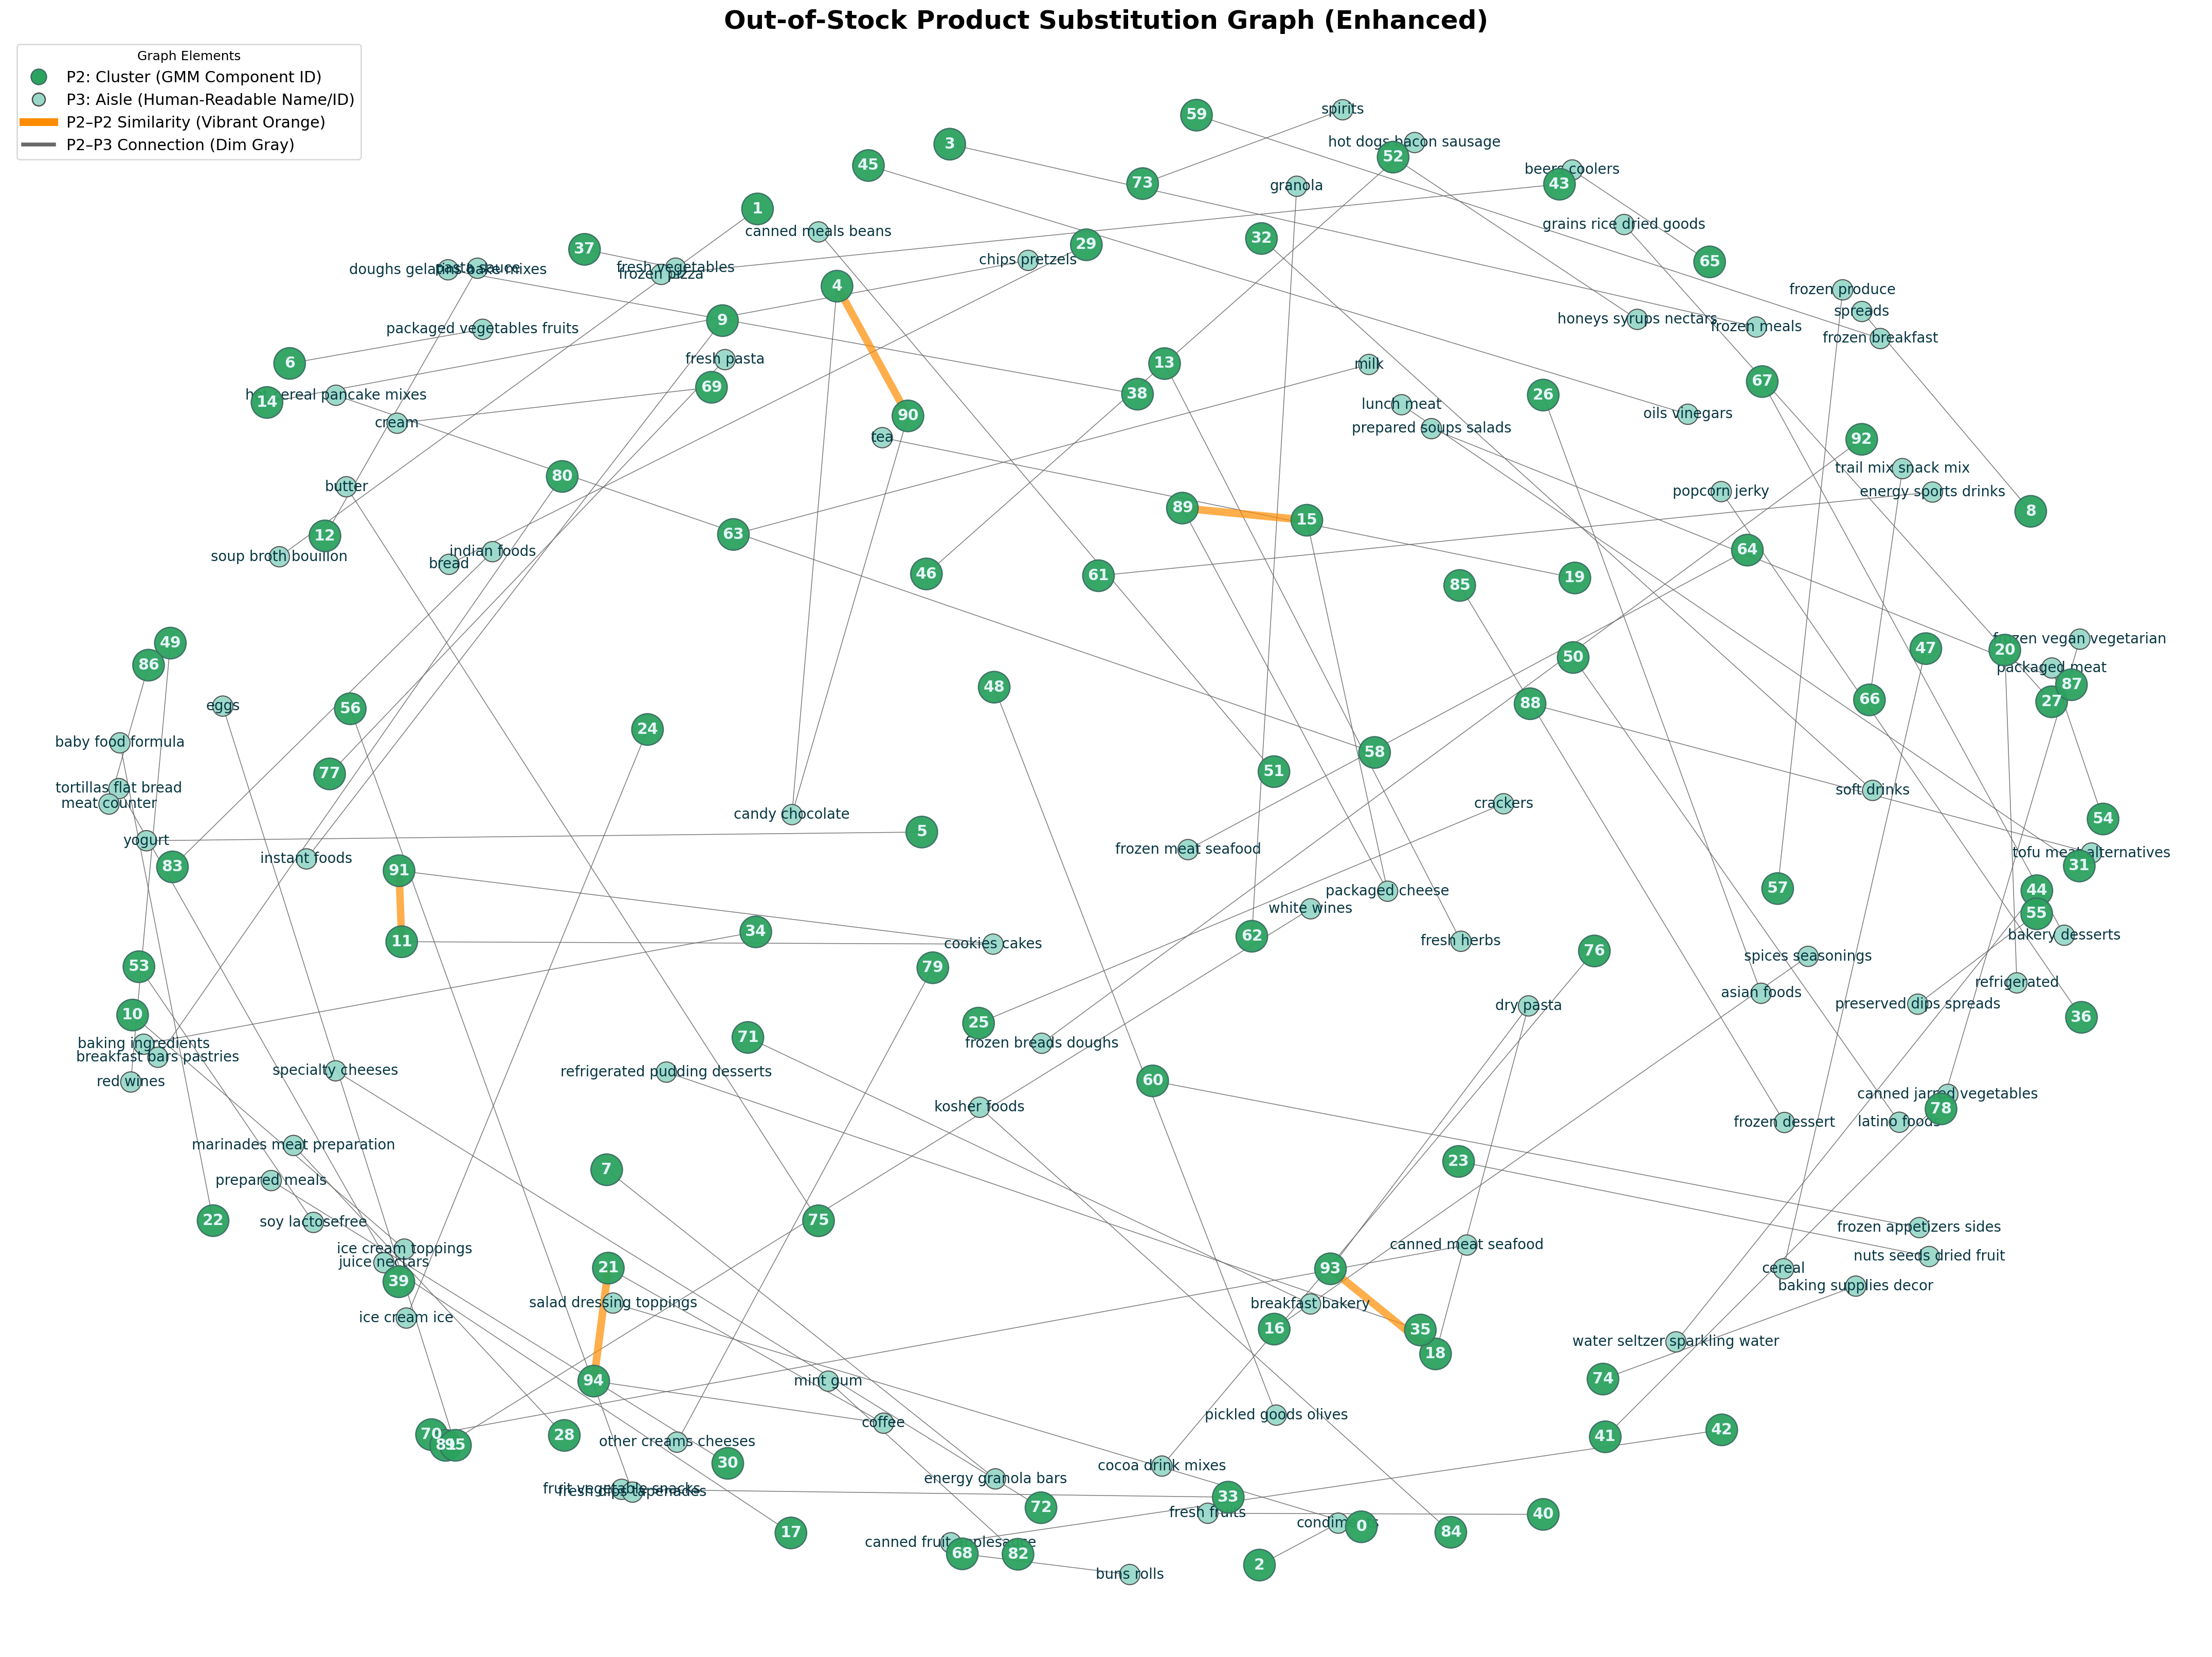

Enhanced graph visualization has been generated with high-prominence lines.


In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import numpy as np
from pathlib import Path

# --- Configuration for Enhanced Visualization ---
ARTIFACTS_DIR = Path("artifacts")
P2_P2_EDGES_FILE = ARTIFACTS_DIR / 'graph' / 'edges_p2_p2_similarity.csv'
P2_P3_EDGES_FILE = ARTIFACTS_DIR / 'graph' / 'edges_p2_p3.csv'
RANDOM_SEED = 42
AISLES_FILE = Path("../data/raw/aisles.csv") 

# --- NODE AND LINE COLOR DEFINITIONS (HIGH CONTRAST) ---

# Node Colors (Keeping the Teal/Green scheme)
BuGn3 = ['#e5f5f9', '#99d8c9', '#2ca25f']
C_P2 = BuGn3[2]    # Dark Teal for Clusters (P2)
C_P3 = BuGn3[1]    # Medium Teal for Aisles (P3)
C_BG = "#ffffff"         

# ENHANCEMENT: High-Prominence Line Colors
C_EdgeP2P2 = '#FF8C00'   # Vibrant Dark Orange for P2-P2 Similarity (prominence)
C_EdgeP2P3 = '#696969'   # Dim Gray for P2-P3 Connection (clear distinction)

# --- Data Loading and Graph Creation ---
try:
    # 1. Load Aisle Names (P3 lookup)
    data_dir_check = Path("../data")
    if (data_dir_check / "raw" / "aisles.csv").exists():
        df_aisles = pd.read_csv(AISLES_FILE)
        aisle_id_to_name = df_aisles.set_index('aisle_id')['aisle'].to_dict()
    else:
        # Fallback using IDs
        df_p2p3_temp = pd.read_csv(P2_P3_EDGES_FILE)
        all_aisle_ids = df_p2p3_temp['aisle_id'].unique()
        aisle_id_to_name = {id: f"A{id}" for id in all_aisle_ids}
    
    # 2. Load Edge Data
    df_p2p2 = pd.read_csv(P2_P2_EDGES_FILE)
    df_p2p3 = pd.read_csv(P2_P3_EDGES_FILE)
    
except FileNotFoundError as e:
    print(f"Error: Required graph artifact file not found. {e.filename}")
    raise RuntimeError("Cannot visualize graph: Missing required CSV artifacts. Please ensure the GMM pipeline ran successfully and saved the CSV files.")

G = nx.Graph()

# Add P2-P2 Edges
df_p2p2['cluster_u'] = df_p2p2['cluster_u'].astype(str)
df_p2p2['cluster_v'] = df_p2p2['cluster_v'].astype(str)
for index, row in df_p2p2.iterrows():
    G.add_edge(row['cluster_u'], row['cluster_v'], 
               weight=row['weight'], 
               type='P2-P2_Similarity', 
               etype='P2-P2')

# Add P2-P3 Edges (Cluster-to-Aisle Name/Label)
df_p2p3['cluster_id'] = df_p2p3['cluster_id'].astype(str)
for index, row in df_p2p3.iterrows():
    aisle_id = row['aisle_id']
    aisle_label = aisle_id_to_name.get(aisle_id, f"A{aisle_id}")
    G.add_edge(row['cluster_id'], aisle_label, 
               weight=row['weight'], 
               type='P2-P3_Connection',
               etype='P2-P3')

# Assign 'layer' and 'label' attribute for drawing helper
for node in G.nodes():
    if node.isdigit(): 
        G.nodes[node]['layer'] = 'P2'
        G.nodes[node]['label'] = node 
    else: 
        G.nodes[node]['layer'] = 'P3'
        G.nodes[node]['label'] = node.replace('A', '')


# --- Visualization Function (Enhanced) ---
def draw_p2p3_graph_enhanced(G, title="Out-of-Stock Product Substitution Graph (Enhanced)"):
    
    node_alpha = 0.95 
    
    # ENHANCEMENT 1: Increased Figure Size and Layout Repulsion
    figsize=(24, 18) 
    pos = nx.spring_layout(G, seed=RANDOM_SEED, k=0.35, iterations=50) 

    p2_nodes = [n for n, d in G.nodes(data=True) if d.get('layer') == 'P2']
    p3_nodes = [n for n, d in G.nodes(data=True) if d.get('layer') == 'P3']

    # --- Sizes ---
    p2_sizes = [600] * len(p2_nodes)
    p3_sizes = [250] * len(p3_nodes)

    e_p2p2 = [(u, v) for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P2']
    e_p2p3 = [(u, v) for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P3']
    
    # ENHANCEMENT 3: Thicker Edges
    p2p2_widths = [d['weight'] * 6 for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P2']
    p2p3_widths = [d['weight'] * 3 for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P3']


    # --- Figure Setup ---
    fig, ax = plt.subplots(figsize=figsize, dpi=180)
    ax.set_facecolor(C_BG)
    ax.axis('off')
    plt.title(title, fontsize=20, weight='bold')

    # --- Edges (Explicit Z-ordering and ENHANCED WIDTH) ---
    def segs(edge_list):
        return [(pos[u], pos[v]) for u, v in edge_list]

    # P2-P3 Edges (Dim Gray)
    lc_p2p3 = LineCollection(segs(e_p2p3), colors=C_EdgeP2P3, linewidths=p2p3_widths, alpha=0.9)
    ax.add_collection(lc_p2p3)
    lc_p2p3.set_zorder(1)
    
    # P2-P2 Edges (Vibrant Orange)
    lc_p2p2 = LineCollection(segs(e_p2p2), colors=C_EdgeP2P2, linewidths=p2p2_widths, alpha=0.7)
    ax.add_collection(lc_p2p2)
    lc_p2p2.set_zorder(1.1)

    # --- Nodes (Explicit Z-ordering) ---
    p3_coll = nx.draw_networkx_nodes(
        G, pos, nodelist=p3_nodes, node_color=C_P3, node_size=p3_sizes,
        edgecolors='#4a4a4a', linewidths=0.8, alpha=node_alpha, ax=ax
    )
    p3_coll.set_zorder(2)

    p2_coll = nx.draw_networkx_nodes(
        G, pos, nodelist=p2_nodes, node_color=C_P2, node_size=p2_sizes,
        edgecolors='#3a6f64', linewidths=1.0, alpha=node_alpha, ax=ax
    )
    p2_coll.set_zorder(3)

    # --- Labels (ENHANCED FONT) ---
    p2_labels = {n: d.get('label', n) for n, d in G.nodes(data=True) if d.get('layer') == 'P2'}
    p2_texts = nx.draw_networkx_labels(G, pos, labels=p2_labels, font_size=12, 
                                       font_weight='bold', font_color='#e5f5f9', ax=ax) 
    for t in p2_texts.values():
        t.set_zorder(4)

    p3_labels = {n: d.get('label', n) for n, d in G.nodes(data=True) if d.get('layer') == 'P3'}
    p3_texts = nx.draw_networkx_labels(G, pos, labels=p3_labels, font_size=11, 
                                       font_color='#073642', ax=ax)
    for t in p3_texts.values():
        t.set_zorder(2.5) 

    # --- Legends ---
    legend_elems = [
        Line2D([0], [0], marker='o', color='w', label='P2: Cluster (GMM Component ID)',
               markerfacecolor=C_P2, markeredgecolor='#3a6f64', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='P3: Aisle (Human-Readable Name/ID)',
               markerfacecolor=C_P3, markeredgecolor='#4a4a4a', markersize=10),
        Line2D([0], [0], color=C_EdgeP2P2, lw=6.0, label='P2–P2 Similarity (Vibrant Orange)'), 
        Line2D([0], [0], color=C_EdgeP2P3, lw=3.0, label='P2–P3 Connection (Dim Gray)'),
    ]
    ax.legend(handles=legend_elems, loc='upper left', title="Graph Elements", fontsize=12)

    plt.tight_layout()
    plt.show()
    
    print("Enhanced graph visualization has been generated with high-prominence lines.")


# --- Final Execution ---
draw_p2p3_graph_enhanced(G)

Looking into Clusters

In [5]:
import pandas as pd
from pathlib import Path

# --- IMPORTANT: Ensure 'pyarrow' or 'fastparquet' is installed in your local environment ---
# You may need to run: pip install pyarrow pandas

# --- Define Paths to Your Artifacts ---
# Modify this path if your 'artifacts' folder is not in the current directory
ARTIFACTS_DIR = Path("artifacts") 
DATA_DIR = Path("../data/raw") # For aisles lookup

META_PRODUCT_PATH = ARTIFACTS_DIR / "features" / "meta_product.parquet"
PRODUCT_TO_BUCKET_PATH = ARTIFACTS_DIR / "buckets" / "product_to_bucket.parquet"
BUCKET_LABELS_PATH = ARTIFACTS_DIR / "gmm" / "bucket_labels.parquet"
BUCKET_INDEX_PATH = ARTIFACTS_DIR / "features" / "bucket_index.parquet"
AISLES_FILE = DATA_DIR / "aisles.csv"

OUTPUT_CSV_PATH = "../data/processed/gmm_cluster_product_details_for_analysis.csv"


def convert_and_join_to_csv():
    print("--- Starting Parquet to CSV Conversion and Data Join ---")
    
    try:
        # Load all necessary files
        df_meta = pd.read_parquet(META_PRODUCT_PATH)
        df_p0_p1 = pd.read_parquet(PRODUCT_TO_BUCKET_PATH)
        df_p1_labels = pd.read_parquet(BUCKET_LABELS_PATH)
        df_p1_idx = pd.read_parquet(BUCKET_INDEX_PATH)
        df_aisles = pd.read_csv(AISLES_FILE)
        
        # 1. Prepare Cluster ID to Bucket ID Mapping (P2 -> P1)
        if len(df_p1_labels.columns) == 1:
            # Map index of labels to bucket_id from the index file
            df_p1_p2 = df_p1_idx.copy()
            df_p1_p2['cluster_id'] = df_p1_labels.iloc[:, 0]
        else:
             # Assume saved file already has correct P1/P2 columns
            df_p1_p2 = df_p1_labels
            df_p1_p2 = df_p1_p2.rename(columns={df_p1_p2.columns[0]: 'cluster_id'})
            
        df_p1_p2['cluster_id'] = df_p1_p2['cluster_id'].astype('Int64', errors='ignore')

        # 2. Join Product Metadata (P0) with Bucket ID (P1)
        df_joined = df_meta[['product_id', 'product_name', 'aisle_id', 'price_per_100g', 'ingredients']].merge(
            df_p0_p1, on='product_id', how='left'
        )
        
        # 3. Join with Cluster ID (P2)
        df_final = df_joined.merge(df_p1_p2, on='bucket_id', how='left')

        # 4. Add Human-Readable Aisle Names
        df_final = df_final.merge(df_aisles[['aisle_id', 'aisle']], on='aisle_id', how='left')
        
        # Select and rename final columns
        df_output = df_final[['cluster_id', 'bucket_id', 'aisle', 'product_name', 'price_per_100g', 'ingredients']]
        df_output = df_output.rename(columns={'cluster_id': 'GMM_Cluster_ID', 'bucket_id': 'P1_Bucket_ID', 'aisle': 'Aisle_Name'})
        
        # 5. Save the final CSV
        df_output.to_csv(OUTPUT_CSV_PATH, index=False)
        
        print(f"Success! The comprehensive cluster analysis file has been saved to: {OUTPUT_CSV_PATH}")

    except ImportError:
        print("\nFATAL ERROR: Parquet read failed.")
        print("Please ensure you have the 'pyarrow' library installed (pip install pyarrow) in your local environment.")
    except FileNotFoundError as e:
        print(f"\nFATAL ERROR: One of the required input files was not found: {e.filename}")
        print("Please verify the paths defined in the script.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during processing: {e}")

if __name__ == "__main__":
    convert_and_join_to_csv()

--- Starting Parquet to CSV Conversion and Data Join ---
Success! The comprehensive cluster analysis file has been saved to: ../data/processed/gmm_cluster_product_details_for_analysis.csv


In [10]:
cluster_data = pd.read_csv(OUTPUT_CSV_PATH)
cluster_data.head(10)


,GMM_Cluster_ID,P1_Bucket_ID,Aisle_Name,product_name,price_per_100g,ingredients
0,11,6081,cookies cakes,Chocolate Sandwich Cookies,93.725000,"Enriched flour (wheat flour, niacin, reduced i..."
1,16,1167,spices seasonings,All-Seasons Salt,100.000000,"Sea salt, organic paprika, organic cane sugar,..."
2,19,27486,tea,Robust Golden Unsweetened Oolong Tea,72.881250,"Purified water, oolong tea, ascorbic acid (vit..."
3,3,29138,frozen meals,Smart Ones Classic Favorites Mini Rigatoni Wit...,100.000000,"Cooked enriched macaroni product (water, enric..."
4,28,12892,marinades meat preparation,Green Chile Anytime Sauce,34.133333,"WATER, TOMATOES (TOMATOES, TOMATO JUICE, SALT,..."
5,17,26037,juice nectars,Pure Coconut Water With Orange,62.250000,"Coconut water, banana puree, coconut sugar."
6,57,8254,frozen produce,Cut Russet Potatoes Steam N' Mash,73.950000,"Potatoes, salt, disodium dihydrogen pyrophosph..."
7,5,16169,yogurt,Light Strawberry Blueberry Yogurt,4.490000,"Strawberry : pasteurized grade a nonfat milk, ..."
8,44,29785,water seltzer sparkling water,Sparkling Orange Juice & Prickly Pear Beverage,52.526316,"Water, sugar, orange juice concentrate, prickl..."
9,20,24296,refrigerated,Peach Mango Juice,97.166667,"Filtered water (sufficient to reconsititute), ..."


The function plot_cluster_drill_down(cluster_id) is now defined.
Example: Listing products for Cluster 24.


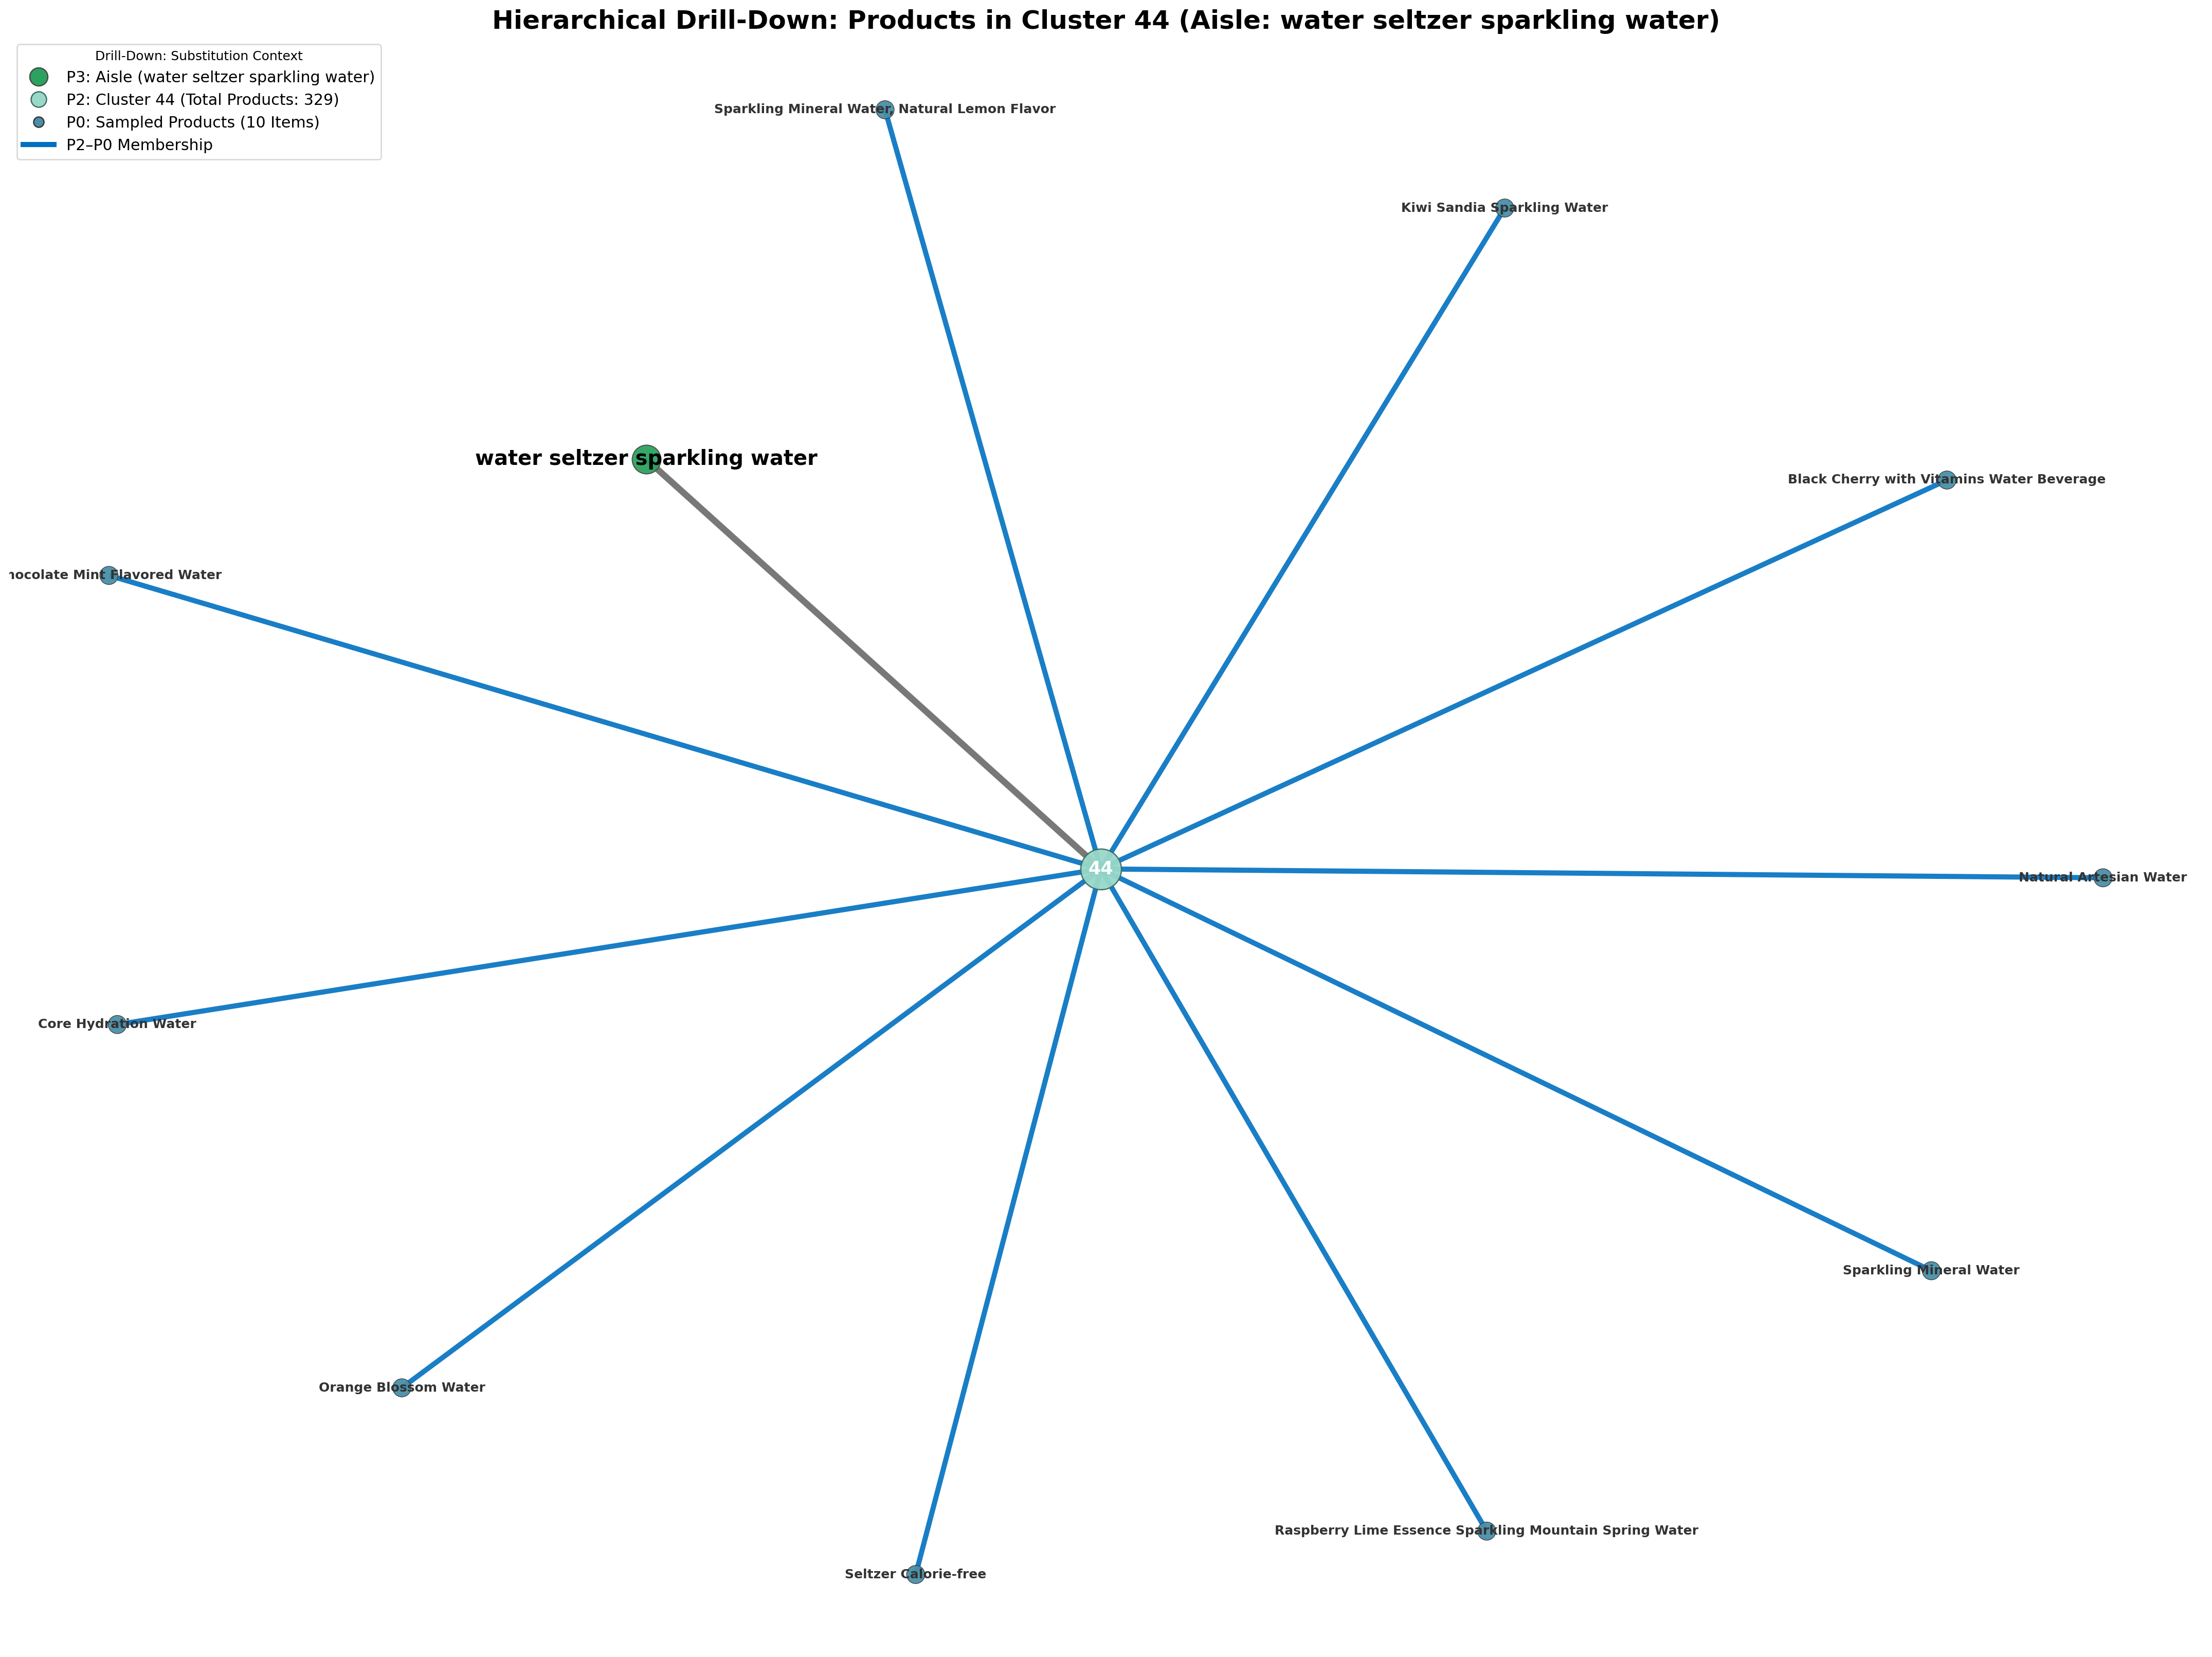

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import numpy as np
from typing import Union

# --- Configuration ---
# Node and Line Color Definitions
BuGn3 = ['#e5f5f9', '#99d8c9', '#2ca25f']

# Hierarchical Color Scheme (Darker for P3 Aisle)
C_P3 = BuGn3[2]    # Dark Teal for Aisle (P3 - Anchor)
C_P2 = BuGn3[1]    # Medium Teal for Clusters (P2 - Central)
C_P0 = '#4A8FA8'    # Blue-Gray for Product (P0)
C_BG = "#ffffff"

# Edge Colors
C_EdgeP2P0 = '#0070C0'  # Dark Blue for P2-P0 Membership (Prominent)
C_EdgeP2P3 = '#696969'  # Dim Gray for P2-P3 Connection (Contextual)
RANDOM_SEED = 42
SAMPLE_SIZE = 10 

def plot_cluster_drill_down(cluster_id: Union[int, str]):
    """
    Generates a drill-down visualization for a specified GMM cluster, 
    with the Aisle node anchored at the top and colored darkest for hierarchy.

    Args:
        cluster_id (Union[int, str]): The GMM Cluster ID to visualize (e.g., 24 or 87).
    """
    
    # --- 1. Load Data and Filter ---
    try:
        df_details = pd.read_csv("../data/processed/gmm_cluster_product_details_for_analysis.csv")
    except FileNotFoundError:
        print("ERROR: Required file 'gmm_cluster_product_details_for_analysis.csv' not found.")
        return

    cluster_id = int(cluster_id)
    df_cluster = df_details[df_details['GMM_Cluster_ID'] == cluster_id]
    
    if df_cluster.empty:
        print(f"ERROR: Cluster ID {cluster_id} not found or contains no products.")
        return
        
    df_sample = df_cluster.sample(n=min(SAMPLE_SIZE, len(df_cluster)), random_state=RANDOM_SEED)

    aisle_name = df_cluster['Aisle_Name'].mode().iloc[0]
    total_products_in_cluster = len(df_cluster)


    # --- 2. Build Drill-Down Graph (P3 -> P2 -> P0) ---
    G = nx.Graph()
    p3_node = aisle_name
    p2_node = str(cluster_id)

    G.add_node(p3_node, layer='P3', label=aisle_name, size=500)
    G.add_node(p2_node, layer='P2', label=str(cluster_id), size=1000)
    G.add_edge(p2_node, p3_node, weight=1.0, type='P2-P3_Strongest', etype='P2-P3')

    p0_nodes = []
    for index, row in df_sample.iterrows():
        p0_node_id = f"P0:{row['product_name']}"
        G.add_node(p0_node_id, layer='P0', label=row['product_name'], size=200)
        G.add_edge(p2_node, p0_node_id, weight=1.0, type='P2-P0_Membership', etype='P2-P0')
        p0_nodes.append(p0_node_id)


    # --- 3. Visualization ---
    
    node_alpha = 0.95 
    figsize=(24, 18) 
    
    # Anchor Aisle Node at the Top
    pos = nx.kamada_kawai_layout(G, scale=2) 
    fixed_nodes = {p3_node}
    p3_pos = {p3_node: np.array([0, 1])}
    pos = nx.spring_layout(G, pos=p3_pos, fixed=fixed_nodes, seed=RANDOM_SEED, k=0.8, iterations=100)


    # Node lists, sizes, and edge widths
    p2_nodes = [n for n, d in G.nodes(data=True) if d.get('layer') == 'P2']
    p3_nodes = [n for n, d in G.nodes(data=True) if d.get('layer') == 'P3']
    
    p3_sizes = [G.nodes[n]['size'] for n in p3_nodes]
    p2_sizes = [G.nodes[n]['size'] for n in p2_nodes]
    p0_sizes = [G.nodes[n]['size'] for n in p0_nodes]

    e_p2p3 = [(u, v) for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P3']
    e_p2p0 = [(u, v) for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P0']
    
    p2p3_widths = [d['weight'] * 5 for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P3']
    p2p0_widths = [d['weight'] * 4 for u, v, d in G.edges(data=True) if d.get('etype') == 'P2-P0']

    # --- Draw Setup ---
    fig, ax = plt.subplots(figsize=(24, 18), dpi=180)
    ax.set_facecolor(C_BG)
    ax.axis('off')
    plt.title(f"Hierarchical Drill-Down: Products in Cluster {cluster_id} (Aisle: {aisle_name})", fontsize=20, weight='bold')

    # --- Draw Edges ---
    def segs(edge_list): return [(pos[u], pos[v]) for u, v in edge_list]

    lc_p2p0 = LineCollection(segs(e_p2p0), colors=C_EdgeP2P0, linewidths=p2p0_widths, alpha=0.9)
    ax.add_collection(lc_p2p0)
    lc_p2p0.set_zorder(1)
    
    lc_p2p3 = LineCollection(segs(e_p2p3), colors=C_EdgeP2P3, linewidths=p2p3_widths, alpha=0.9)
    ax.add_collection(lc_p2p3)
    lc_p2p3.set_zorder(1.5)
    
    # --- Draw Nodes ---
    p0_coll = nx.draw_networkx_nodes(G, pos, nodelist=p0_nodes, node_color=C_P0, node_size=p0_sizes, edgecolors='#333333', linewidths=0.5, alpha=node_alpha, ax=ax)
    p0_coll.set_zorder(2)
    
    p3_coll = nx.draw_networkx_nodes(G, pos, nodelist=p3_nodes, node_color=C_P3, node_size=p3_sizes, edgecolors='#4a4a4a', linewidths=0.8, alpha=node_alpha, ax=ax)
    p3_coll.set_zorder(2.5)

    p2_coll = nx.draw_networkx_nodes(G, pos, nodelist=p2_nodes, node_color=C_P2, node_size=p2_sizes, edgecolors='#3a6f64', linewidths=1.0, alpha=node_alpha, ax=ax)
    p2_coll.set_zorder(3)

    # --- Draw Labels ---
    def draw_labels_with_zorder(nodes, font_size, font_color, z_order):
        labels_dict = {n: G.nodes[n]['label'] for n in nodes}
        # ENHANCEMENT: All labels are now bold.
        texts = nx.draw_networkx_labels(G, pos, labels=labels_dict, font_size=font_size, font_weight='bold', font_color=font_color, ax=ax)
        for text_obj in texts.values(): text_obj.set_zorder(z_order)

    # P3 Labels (Aisle Name) - Black, Bold, Size 16
    draw_labels_with_zorder(p3_nodes, 16, '#000000', 4)       
    
    # P2 Labels (Cluster ID) - White, Bold, Size 14
    draw_labels_with_zorder(p2_nodes, 14, '#FFFFFF', 5)     
    
    # P0 Labels (Product Name) - Dark Gray, Bold, Size 10
    draw_labels_with_zorder(p0_nodes, 10, '#333333', 6)     
    
    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'P3: Aisle ({aisle_name})',
               markerfacecolor=C_P3, markeredgecolor='#4a4a4a', markersize=14),
        Line2D([0], [0], marker='o', color='w', label=f'P2: Cluster {cluster_id} (Total Products: {total_products_in_cluster})',
               markerfacecolor=C_P2, markeredgecolor='#3a6f64', markersize=12),
        Line2D([0], [0], marker='o', color='w', label=f'P0: Sampled Products ({len(df_sample)} Items)',
               markerfacecolor=C_P0, markeredgecolor='#333333', markersize=8),
        Line2D([0], [0], color=C_EdgeP2P0, lw=4.0, label='P2–P0 Membership'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', title="Drill-Down: Substitution Context", fontsize=12)

    plt.tight_layout()
    plt.show()


# --- Execution ---
print("The function plot_cluster_drill_down(cluster_id) is now defined.")
print("Example: Listing products for Cluster 24.")
plot_cluster_drill_down(44)

In [8]:
product_to_bucket_df = pd.read_parquet(PRODUCT_TO_BUCKET_PATH)
product_to_bucket_df.head()

,product_id,bucket_id
0,25773,1
1,2158,2
2,26381,3
3,20604,4
4,40776,5


In [14]:
final_cluster_df = pd.merge(product_to_bucket_df, cluster_data, how='left', left_on=product_to_bucket_df['bucket_id'], right_on=cluster_data['P1_Bucket_ID'])
final_cluster_df.head(10)

,key_0,product_id,bucket_id,GMM_Cluster_ID,P1_Bucket_ID,Aisle_Name,product_name,price_per_100g,ingredients
0,1,25773,1,21,1,coffee,#2 Coffee Filters,100.000000,"FSC certified pulp (BPI Certified Compostable,..."
1,2,2158,2,94,2,coffee,#2 Cone White Coffee Filters,100.000000,"Corn syrup, sugar, peppermint oil, titanium di..."
2,3,26381,3,94,3,coffee,#4 Natural Brown Coffee Filters,100.000000,"FSC certified pulp (BPI Certified Compostable,..."
3,4,20604,4,8,4,spreads,& Go! Hazelnut Spread + Pretzel Sticks,49.573864,"Nutella: sugar, palm oil, hazelnuts, cocoa, sk..."
4,5,40776,5,17,5,juice nectars,(70% Juice!) Mountain Raspberry Juice Squeeze,62.250000,100% natural juice freshly pressed from select...
5,6,11908,6,20,6,refrigerated,+Energy Black Cherry Vegetable & Fruit Juice,97.166667,"Water, citric acid, propylene glycol, caffeine..."
6,7,7494,7,5,7,yogurt,0% Fat Black Cherry Greek Yogurt y,4.490000,"milk, cream, cane suger, natural flavors, vani..."
7,8,3756,8,5,8,yogurt,0% Fat Blueberry Greek Yogurt,4.490000,"Cultured pasteurized grade a nonfat milk, suga..."
8,9,49517,9,63,9,milk,0% Fat Free Organic Milk,100.000000,"Organic grade a fat free milk, vitamin a palmi..."
9,10,22022,10,5,10,yogurt,0% Fat Greek Yogurt Black Cherry on the Bottom,4.490000,"Cultured nonfat milk, black cherries, cane sug..."


In [15]:
final_cluster_df = final_cluster_df.drop(columns='bucket_id')
final_cluster_df

,key_0,product_id,GMM_Cluster_ID,P1_Bucket_ID,Aisle_Name,product_name,price_per_100g,ingredients
0,1,25773,21,1,coffee,#2 Coffee Filters,100.000000,"FSC certified pulp (BPI Certified Compostable,..."
1,2,2158,94,2,coffee,#2 Cone White Coffee Filters,100.000000,"Corn syrup, sugar, peppermint oil, titanium di..."
2,3,26381,94,3,coffee,#4 Natural Brown Coffee Filters,100.000000,"FSC certified pulp (BPI Certified Compostable,..."
3,4,20604,8,4,spreads,& Go! Hazelnut Spread + Pretzel Sticks,49.573864,"Nutella: sugar, palm oil, hazelnuts, cocoa, sk..."
4,5,40776,17,5,juice nectars,(70% Juice!) Mountain Raspberry Juice Squeeze,62.250000,100% natural juice freshly pressed from select...
...,...,...,...,...,...,...,...,...
35901,35196,35457,87,35196,prepared soups salads,Zucchini Soup,72.881250,"Tomatoes, tomatoes, tomatoes puree, salt, citr..."
35902,35197,49381,37,35197,fresh vegetables,Zucchini Squash,100.000000,Zucchini squash.
35903,35198,1929,6,35198,packaged vegetables fruits,"Zucchini Squash, Baby Courgette",83.000000,Zucchini.
35904,35199,35545,57,35199,frozen produce,"Zucchini, Carrots & Onion",73.950000,"Roasted Zucchini, Roasted Carrots, Roasted Oni..."


In [16]:
final_cluster_df.to_csv(OUTPUT_CSV_PATH, index=False)